### **Notebook 05: Primary Statistical Analysis and Hypothesis Testing**

This notebook conducts the primary statistical analyses of the project, building upon the curated data cohorts from Notebook 04. It will test the central hypotheses regarding attentional allocation to people versus the background (Cohort 1) and the competition between faces and hands (Cohort 2). The notebook integrates a comprehensive suite of sensitivity analyses to ensure the findings are reliable and not driven by methodological artifacts. This notebook represents the culmination of the data processing pipeline, where the project's core hypotheses are formally tested. By loading the high-fidelity, curated data cohorts, we can perform statistically sound comparisons of attentional allocation. 

---

**Analysis Plan**

**Primary endpoints:**

* **E1 (Cohort 1):** Mean log density ratio Λ = log(dens\_P) - log(dens\_O). Report 95 percent bootstrap CI; Wilcoxon signed-rank test $H_{0}$: median Λ = 0; rank-biserial correlation r. Also report the geometric mean density ratio exp(mean log ratio).
* **E2 (Cohort 2):** Mean log density ratio Δ = log(dens\_F) - log(dens\_H). Report 95 percent bootstrap CI; Wilcoxon signed-rank test $H_{0}$: median Δ = 0; rank-biserial correlation r.

**Secondary and sensitivity analyses:**
All sensitivity analyses are confirmatory; conclusions are based on the two primary endpoints.

* Center-prior enrichment estimate for Cohort 1 using a data-driven Gaussian prior whose $\sigma$ values are estimated from pooled fixations with the same loader as Notebook 01.
* Boundary exclusion (about 1 degree visual angle band) for Cohort 1.
* Category-balanced mean and Leave-One-Category-Out (LOCO) for Cohort 1.
* Eccentricity-binned means for Cohort 1.
* Leave-One-Image-Out (LOO) leverage check for Cohort 1.
* Face∩Hand overlap-excluded estimate for Cohort 2.

**Determinism:** All bootstraps and sampling use `SEED = 42`. Continuity correction for density calculations uses `ALPHA = 0.5` and `BETA = 1e-6`.

---

### **Section 0: Setup and Configuration**

In [21]:
# --- Section 0: Setup and Configuration ---

# --- Standard libraries and third-party imports ---
import sys
import warnings
import random
import json
from pathlib import Path
from typing import List, Dict, Tuple, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from scipy.stats import wilcoxon, rankdata
from scipy.ndimage import distance_transform_edt, center_of_mass
from pandas.api.types import CategoricalDtype

# --- Project-specific imports and configuration ---
# This assumes the notebook is in notebooks/ and config.py is in src/
sys.path.insert(0, str(Path("../src").resolve()))
import config

# --- Notebook-specific constants ---
NOTEBOOK_NUM = 5
SEED = 42
ALPHA = 0.5  # Continuity correction for counts
BETA = 1e-6  # Continuity correction for areas
BOOT_B = 5000  # Number of bootstrap resamples

# --- Helper Functions ---

def get_output_path(section_num: int, filename: str) -> Path:
    """Generates a standardized output path for notebook artifacts."""
    output_dir = config.RESULTS_DIR / f"notebook{NOTEBOOK_NUM:02d}" / f"section{section_num:02d}"
    output_dir.mkdir(parents=True, exist_ok=True)
    return output_dir / filename

def enforce_category_order_safe(df: pd.DataFrame, col: str = "category") -> pd.DataFrame:
    """
    Enforces canonical category ordering for rows whose category appears in config.CAT_ORDER.
    Rows with other category values (for example 'Global') are left in place and appended after the ordered block.
    If CAT_ORDER is missing, returns the DataFrame unchanged.
    """
    if col not in df.columns:
        return df.copy()
    cat_order = getattr(config, "CAT_ORDER", None)
    if not cat_order:
        return df.copy()

    d = df.copy()
    d[col] = d[col].astype(str)
    mask = d[col].isin(cat_order)

    ordered_block = d.loc[mask].copy()
    remainder = d.loc[~mask].copy()

    if not ordered_block.empty:
        present_order = [c for c in cat_order if c in ordered_block[col].unique()]
        dtype = pd.CategoricalDtype(present_order, ordered=True)
        ordered_block[col] = ordered_block[col].astype(dtype)
        ordered_block = ordered_block.sort_values(col)

    return pd.concat([ordered_block, remainder]).reset_index(drop=True)

def save_dataframe_as_markdown(df: pd.DataFrame, filepath: Path, title: str = ""):
    """Saves a DataFrame to Markdown with consistent numeric formatting."""
    df_fmt = enforce_category_order_safe(df.copy())
    for col in df_fmt.select_dtypes(include=[float]).columns:
        df_fmt[col] = df_fmt[col].map(lambda x: "" if pd.isna(x) else f"{x:.3f}")
    with open(filepath, "w", encoding="utf-8") as f:
        if title:
            f.write(f"## {title}\n\n")
        f.write(df_fmt.to_markdown(index=False))
    print(f"[saved] {filepath}")

def bootstrap_mean_ci(x: np.ndarray, B: int = BOOT_B, alpha: float = 0.05, seed: int = SEED):
    """
    Computes a percentile bootstrap CI for the mean.
    Returns (mean, (lo, hi)) on the scale of x.
    """
    x = np.asarray(x, float)
    if x.size == 0:
        return np.nan, (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    boots = rng.choice(x, size=(B, x.size), replace=True).mean(axis=1)
    lo, hi = np.quantile(boots, [alpha / 2, 1 - alpha / 2])
    return float(x.mean()), (float(lo), float(hi))

def rank_biserial_from_wilcoxon(diffs: np.ndarray) -> float:
    """
    Computes rank-biserial correlation r for the Wilcoxon signed-rank test.
    Zeros are dropped to match zero_method='wilcox'.
    """
    d = np.asarray(diffs, float)
    d = d[d != 0]
    n = d.size
    if n == 0:
        return np.nan
    r = rankdata(np.abs(d), method="average")
    W_pos = r[d > 0].sum()
    W_neg = r[d < 0].sum()
    return (W_pos - W_neg) / (n * (n + 1) / 2.0)

# --- Environment Setup ---
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

# Configure seaborn palette with a safe fallback
cat_order = list(getattr(config, "CAT_ORDER", []))
palette_lookup = getattr(config, "CATEGORY_COLORS", {})
_palette = [palette_lookup.get(c) for c in cat_order] if cat_order else []
if not _palette or any(p is None for p in _palette):
    sns.set_theme(style="whitegrid")
else:
    sns.set_theme(style="whitegrid", palette=_palette)

# Determinism
random.seed(SEED)
np.random.seed(SEED)

# --- Configuration Snapshot ---
print("[config] Project configuration")
for key, value in sorted({k: v for k, v in config.__dict__.items() if k.isupper() and not k.startswith("_")}.items()):
    if isinstance(value, Path):
        value = str(value)
    print(f"{key:<28}: {value}")

print(f"{'SEED':<28}: {SEED}")
print(f"{'ALPHA':<28}: {ALPHA}")
print(f"{'BETA':<28}: {BETA}")
print(f"{'BOOT_B':<28}: {BOOT_B}")

print("\n[ok] Preamble setup complete.")

[config] Project configuration
ANTHROPOMORPHIC_CATEGORIES  : ['Action', 'Affective', 'Social']
BOXPLOT_WIDTH               : 0.45
CAT2000_DIR                 : /home/nico/Projects/final_project/data/CAT2000/trainSet
CATEGORIES                  : ['Action', 'Affective', 'Social', 'Indoor', 'OutdoorManMade', 'OutdoorNatural']
CATEGORY_COLORS             : {'Action': '#7ad151', 'Affective': '#414487', 'Social': '#fde725', 'Indoor': '#22a884', 'OutdoorManMade': '#2a7886', 'OutdoorNatural': '#440154'}
CATEGORY_ORDER              : ['Action', 'Affective', 'Social', 'Indoor', 'OutdoorManMade', 'OutdoorNatural']
CATEGORY_PALETTE            : ['#7ad151', '#414487', '#fde725', '#22a884', '#2a7886', '#440154']
CAT_ORDER                   : ['Action', 'Affective', 'Social', 'Indoor', 'OutdoorManMade', 'OutdoorNatural']
CENTER_BIAS_SIGMA_X_FRAC    : 0.3
CENTER_BIAS_SIGMA_Y_FRAC    : 0.3
DATA_DIR                    : /home/nico/Projects/final_project/data
DBSCAN_EPS                  : 60
DBSCAN_MIN_

---

### **Section 1: Data Loading and Invariant Checks**

**Objective**

To load all necessary data from previous notebooks, apply the canonical category mappings, and perform critical integrity checks to ensure the data is sound before analysis.

**Rationale**

This initial step is required for ensuring the reliability of all subsequent analyses. By loading data from the canonical outputs of previous notebooks and running invariant checks.

**Methodology**

The analysis loads the final, curated fixation assignment tables produced in Notebook 04. A series of `assert` statements then verify data integrity. For Cohort 1, it checks that the sum of person and outside fixations equals the total number of in-bounds fixations. For Cohort 2, it confirms that the sum of face, hand, body, and outside fixations equals the total, and that the sum of face, hand, and body areas equals the total person area. 

**Inputs**

* `results/notebook04/section06/tbl_fixation_assignment_cohort1.csv`
* `results/notebook04/section06/tbl_fixation_assignment_cohort2.csv`

**Outputs**

* `df_c1_analysis`: A clean, validated DataFrame for Cohort 1 analysis.
* `df_c2_analysis`: A clean, validated DataFrame for Cohort 2 analysis.
* `results/notebook05/section01/tbl_category_counts.md`: Per-category image counts for both cohorts.

In [5]:
# --- Section 1: Data Loading and Invariant Checks ---

def attach_group_and_order(df: pd.DataFrame, col="category"):
    out = df.copy()
    out[col] = pd.Categorical(out[col], categories=config.CAT_ORDER, ordered=True)
    out["group"] = out[col].map(config.GROUP_MAP)
    out["group"] = pd.Categorical(out["group"], categories=config.GROUP_ORDER, ordered=True)
    return out

def _assert_has_columns(df: pd.DataFrame, cols: list, name: str):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"{name} is missing required columns: {missing}")

def _save_counts_markdown(df_c1: pd.DataFrame, df_c2: pd.DataFrame):
    counts = pd.DataFrame({
        "category": config.CAT_ORDER,
        "Cohort 1": df_c1["category"].value_counts().reindex(config.CAT_ORDER).fillna(0).astype(int).values,
        "Cohort 2": df_c2["category"].value_counts().reindex(config.CAT_ORDER).fillna(0).astype(int).values,
    })
    save_dataframe_as_markdown(counts, get_output_path(1, "tbl_category_counts.md"), title="Per-Category Image Counts")

# --- 1. Load Data ---

# Paths
c1_assign_path = config.RESULTS_DIR / "notebook04" / "section06" / "tbl_fixation_assignment_cohort1.csv"
c2_assign_path = config.RESULTS_DIR / "notebook04" / "section06" / "tbl_fixation_assignment_cohort2.csv"

# Fail-fast existence checks
assert c1_assign_path.exists(), f"Missing Cohort 1 assignments at {c1_assign_path}"
assert c2_assign_path.exists(), f"Missing Cohort 2 assignments at {c2_assign_path}"

# Load
df_c1 = pd.read_csv(c1_assign_path)
df_c2 = pd.read_csv(c2_assign_path)

# Apply canonical category mapping
df_c1 = attach_group_and_order(df_c1)
df_c2 = attach_group_and_order(df_c2)

# Validate categories are known
unknown_c1 = set(df_c1["category"].astype(str)) - set(config.CAT_ORDER)
unknown_c2 = set(df_c2["category"].astype(str)) - set(config.CAT_ORDER)
if unknown_c1:
    raise ValueError(f"Cohort 1 has unknown categories: {sorted(unknown_c1)}")
if unknown_c2:
    raise ValueError(f"Cohort 2 has unknown categories: {sorted(unknown_c2)}")

# Harmonize dtypes for safety
int_cols_c1 = ["n_P", "n_O", "n_gt_total", "A_P", "A_O"]
int_cols_c2 = ["n_F", "n_H", "n_B", "n_O", "n_gt_total", "A_F", "A_H", "A_B", "A_P"]
df_c1[int_cols_c1] = df_c1[int_cols_c1].apply(pd.to_numeric, downcast="integer", errors="raise")
df_c2[int_cols_c2] = df_c2[int_cols_c2].apply(pd.to_numeric, downcast="integer", errors="raise")

print(f"[load] Cohort 1 images: {len(df_c1)}")
print(f"[load] Cohort 2 images: {len(df_c2)}")
print("[load] Cohort 1 per-category counts:")
print(df_c1["category"].value_counts(dropna=False).reindex(config.CAT_ORDER).fillna(0).astype(int))
print("[load] Cohort 2 per-category counts:")
print(df_c2["category"].value_counts(dropna=False).reindex(config.CAT_ORDER).fillna(0).astype(int))

# Persist counts snapshot for auditability
_save_counts_markdown(df_c1, df_c2)

# --- 2. Invariant Checks (Fail-Fast) ---

# Column presence
_req_c1 = ["image_id", "category", "n_P", "n_O", "n_gt_total", "A_P", "A_O"]
_req_c2 = ["image_id", "category", "n_F", "n_H", "n_B", "n_O", "n_gt_total", "A_F", "A_H", "A_B", "A_P"]
_assert_has_columns(df_c1, _req_c1, "Cohort 1")
_assert_has_columns(df_c2, _req_c2, "Cohort 2")

# Uniqueness
if df_c1["image_id"].duplicated().any():
    dups = df_c1.loc[df_c1["image_id"].duplicated(), "image_id"].tolist()
    raise ValueError(f"Cohort 1 has duplicated image_id entries: {dups[:10]}{' ...' if len(dups) > 10 else ''}")
if df_c2["image_id"].duplicated().any():
    dups = df_c2.loc[df_c2["image_id"].duplicated(), "image_id"].tolist()
    raise ValueError(f"Cohort 2 has duplicated image_id entries: {dups[:10]}{' ...' if len(dups) > 10 else ''}")

# Missing values
assert not df_c1[int_cols_c1].isnull().values.any(), "Missing values in Cohort 1"
assert not df_c2[int_cols_c2].isnull().values.any(), "Missing values in Cohort 2"

# Non-negativity
assert (df_c1[int_cols_c1] >= 0).all().all(), "Negative values in Cohort 1"
assert (df_c2[int_cols_c2] >= 0).all().all(), "Negative values in Cohort 2"

# Conservation of fixations
assert np.all(df_c1["n_P"] + df_c1["n_O"] == df_c1["n_gt_total"]), "Fixation conservation failed for Cohort 1"
assert np.all(df_c2["n_F"] + df_c2["n_H"] + df_c2["n_B"] + df_c2["n_O"] == df_c2["n_gt_total"]), "Fixation conservation failed for Cohort 2"

# Conservation of area
IMG_PIXELS = int(config.IMG_HEIGHT) * int(config.IMG_WIDTH)
assert np.all(df_c1["A_P"] + df_c1["A_O"] == IMG_PIXELS), "Area conservation failed for Cohort 1"
assert np.all(df_c2["A_F"] + df_c2["A_H"] + df_c2["A_B"] == df_c2["A_P"]), "Area conservation failed for Cohort 2 (within-person)"

print("[info] All invariant checks passed.")

# --- 3. Prepare Final Analysis DataFrames ---
df_c1_analysis = df_c1.copy()
df_c2_analysis = df_c2.copy()

[load] Cohort 1 images: 181
[load] Cohort 2 images: 32
[load] Cohort 1 per-category counts:
category
Action            80
Affective         63
Social            38
Indoor             0
OutdoorManMade     0
OutdoorNatural     0
Name: count, dtype: int64
[load] Cohort 2 per-category counts:
category
Action            12
Affective         10
Social            10
Indoor             0
OutdoorManMade     0
OutdoorNatural     0
Name: count, dtype: int64
[saved] /home/nico/Projects/final_project/results/notebook05/section01/tbl_category_counts.md
[info] All invariant checks passed.


<positron-console-cell-5>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


### **Section 2: Primary Endpoint 1: Person vs. Outside (Cohort 1)**

**Objective**

To quantify and test the attentional advantage of people over the background using the curated Cohort 1 dataset. This section addresses the project's first primary endpoint, including a crucial sensitivity check to account for the influence of a generic center bias.

**Rationale**

The central hypothesis of this project is that human attention is systematically directed toward social agents (people) far more than would be predicted by their spatial area alone. This analysis formalizes that hypothesis by computing a size-corrected attentional advantage metric (the log density ratio, Λ). By testing this metric against a null hypothesis of zero advantage and supplementing it with a center-bias corrected estimate, we can robustly determine the magnitude and statistical significance of this effect.

**Methodology**

For each image in Cohort 1, the per-pixel fixation density is calculated for the `person` region and the `outside` region. The natural logarithm of the ratio of these densities (Λ) is computed. Two primary estimates are generated:

1. **Naive estimate:** The mean Λ is computed directly from the observed fixation and area data, and reported alongside its geometric mean density ratio exp(mean log ratio).
2. **Center-corrected estimate:** A data-driven Gaussian center-bias prior is constructed. Its $\sigma_x$ and $\sigma_y$ are estimated by pooling fixation counts from the CAT2000 .mat files for the Cohort 1 images, rasterizing them to H×W maps using the same robust loader as in earlier notebooks, then computing intensity-weighted second moments around the image center. Observed fixation counts are adjusted by this prior to yield a center-corrected Λ.

**Inputs**

* `df_c1_analysis`: The validated and prepared DataFrame for Cohort 1 from Section 1.

**Outputs**

* `results/notebook05/section02/tbl_c1_primary_endpoint.csv`
* `results/notebook05/section02/fig_person_advantage_ecdf.png`
* `results/notebook05/section02/fig_center_prior.png`

[info] Estimated center-bias sigmas from pooled fixmaps: sigma_x=267.29px (0.139x W), sigma_y=206.74px (0.191x H)
[saved] /home/nico/Projects/final_project/results/notebook05/section02/fig_center_prior.png
[saved] /home/nico/Projects/final_project/results/notebook05/section02/tbl_c1_primary_endpoint.md

[table] Person Advantage: Naive vs. Center-Corrected


,Estimate,Mean Log Ratio,95% CI (Log),Mean Density Ratio (x),95% CI (x),Wilcoxon p-value,Rank-biserial r
0,Naive,2.131,"[1.997, 2.266]",8.424,"[7.37x, 9.64x]",2.40577e-31,0.998179
1,Center-Corrected,0.994,"[0.898, 1.092]",2.702,"[2.46x, 2.98x]",N/A,N/A


Text(0.5, 0, 'Allocation Advantage Λ = log(dens_P) - log(dens_O)')

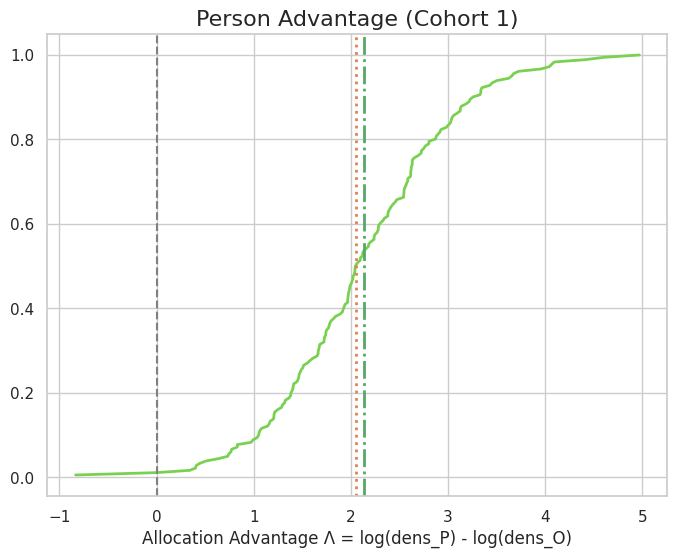

In [40]:
# --- Section 2: Primary Endpoint 1: Person vs. Outside (Cohort 1) ---

def per_image_log_ratio(df: pd.DataFrame) -> pd.DataFrame:
    """Computes per-image fixation densities and their log-ratio (Lambda)."""
    d = df.copy()
    d["dens_P"] = (d["n_P"] + ALPHA) / (d["A_P"] + BETA)
    d["dens_O"] = (d["n_O"] + ALPHA) / (d["A_O"] + BETA)
    d["log_ratio"] = np.log(d["dens_P"]) - np.log(d["dens_O"])
    return d

def _create_center_prior_gaussian(H: int, W: int, sigma_x_frac: float, sigma_y_frac: float) -> np.ndarray:
    """
    Builds a normalized 2D Gaussian prior centered in the image.
    Sigmas are provided as a fraction of width/height (data-driven).
    """
    sx = max(1.0, sigma_x_frac * W)
    sy = max(1.0, sigma_y_frac * H)
    y, x = np.mgrid[0:H, 0:W]
    cy, cx = H / 2.0, W / 2.0
    exponent = -(((x - cx) ** 2) / (2 * sx ** 2) + ((y - cy) ** 2) / (2 * sy ** 2))
    prior = np.exp(exponent)
    prior /= prior.sum()
    return prior

def _load_bool_mask(json_path: Path, expected_hw: Tuple[int, int]) -> np.ndarray | None:
    """Loads a 2D boolean mask saved as JSON 0/1 array. Returns None if missing or wrong shape."""
    if not json_path.exists():
        return None
    arr = np.asarray(json.loads(json_path.read_text(encoding="utf-8")), dtype=np.uint8)
    if arr.shape != expected_hw:
        return None
    return arr.astype(bool)

def _fmt_p_full(p: float, sigfigs: int = 6) -> str:
    """Formats p-values with full numeric precision using general format."""
    if np.isnan(p):
        return ""
    return f"{p:.{sigfigs}g}"

def _load_fixation_mat_robust(mat_path: Path) -> Tuple[np.ndarray, int, int]:
    """
    Returns (fixation_map HxW int32, total_fixations_in_file, out_of_bounds_count_before_clipping).
    Accepts either a precomputed HxW map or Nx2 / 2xN coordinate arrays. Handles 1-based coords.
    """
    H, W = int(config.IMG_HEIGHT), int(config.IMG_WIDTH)
    if not mat_path.exists():
        raise FileNotFoundError(f"Missing fixation file: {mat_path}")

    m = scipy.io.loadmat(mat_path)
    keys = ("fixLocs", "gnd", "fixLocsXY", "fixLocs_XY", "fixations", "map", "fixmap", "fixation_map")
    arr = next((np.asarray(m[k]) for k in keys if k in m), None)
    if arr is None or arr.size == 0:
        raise ValueError(f"Unknown or empty fixation format in {mat_path.name}")

    # Case A - raster map provided
    if arr.ndim == 2 and arr.shape == (H, W):
        fm = np.rint(np.clip(arr, a_min=0, a_max=None)).astype(np.int32)
        return fm, int(fm.sum()), 0

    # Case B - coordinates -> rasterize
    if arr.ndim == 2:
        coords = arr if arr.shape[1] == 2 else arr.T
        if coords.shape[1] != 2:
            raise ValueError(f"Fixation coords must be Nx2 or 2xN in {mat_path.name}")

        x_raw = coords[:, 0].astype(float)
        y_raw = coords[:, 1].astype(float)
        total = int(coords.shape[0])

        # Heuristic for 1-based data (as in earlier notebooks)
        one_based = (x_raw.min() >= 1) and (y_raw.min() >= 1) and (x_raw.max() <= W) and (y_raw.max() <= H)
        if one_based:
            x_raw -= 1.0
            y_raw -= 1.0

        x = np.rint(x_raw).astype(np.int64)
        y = np.rint(y_raw).astype(np.int64)
        oob_mask = (x < 0) | (x >= W) | (y < 0) | (y >= H)
        n_oob = int(oob_mask.sum())
        xs = np.clip(x, 0, W - 1).astype(np.int32)
        ys = np.clip(y, 0, H - 1).astype(np.int32)

        fm = np.zeros((H, W), dtype=np.int32)
        np.add.at(fm, (ys, xs), 1)
        return fm, total, n_oob

    raise ValueError(f"Unhandled fixation array shape {arr.shape} in {mat_path.name}")

# --- Estimate Gaussian sigmas by pooling fixation maps across Cohort 1 ---

def _estimate_center_sigma_from_fixmaps(df_c1: pd.DataFrame) -> Tuple[float, float]:
    """
    Pool fixation mass over Cohort 1, then compute intensity-weighted second moments
    around the image center. Returns (sigma_x_frac, sigma_y_frac).
    """
    H, W = int(config.IMG_HEIGHT), int(config.IMG_WIDTH)
    cx, cy = W / 2.0, H / 2.0

    # Precompute coordinate grids once
    yy, xx = np.indices((H, W), dtype=np.float64)

    sum_dx2 = 0.0
    sum_dy2 = 0.0
    total_mass = 0.0

    for _, row in df_c1.iterrows():
        stem = Path(row["filename"]).stem
        cat = row["category"]
        mat_path = config.FIXATIONLOCS_DIR / cat / f"{stem}.mat"
        try:
            fm, total, _ = _load_fixation_mat_robust(mat_path)
        except Exception:
            continue
        if total <= 0:
            continue

        sum_dx2 += float(((xx - cx) ** 2 * fm).sum())
        sum_dy2 += float(((yy - cy) ** 2 * fm).sum())
        total_mass += float(fm.sum())

    if total_mass <= 0:
        # Last resort: fall back to config defaults to avoid failure
        sx_frac = float(getattr(config, "CENTER_BIAS_SIGMA_X_FRAC", 0.30))
        sy_frac = float(getattr(config, "CENTER_BIAS_SIGMA_Y_FRAC", 0.30))
        print(f"[warn] No usable fixations found while estimating center bias; using config fallbacks "
              f"({sx_frac}, {sy_frac}).")
        return sx_frac, sy_frac

    sigma_x_pix = float(np.sqrt(sum_dx2 / total_mass))
    sigma_y_pix = float(np.sqrt(sum_dy2 / total_mass))

    # Convert to fractions of width/height and clamp to sane bounds
    sigma_x_frac = max(1.0 / W, min(0.95, sigma_x_pix / W))
    sigma_y_frac = max(1.0 / H, min(0.95, sigma_y_pix / H))

    print(f"[info] Estimated center-bias sigmas from pooled fixmaps: "
          f"sigma_x={sigma_x_pix:.2f}px ({sigma_x_frac:.3f}x W), "
          f"sigma_y={sigma_y_pix:.2f}px ({sigma_y_frac:.3f}x H)")
    return sigma_x_frac, sigma_y_frac

# --- 1. Naive Analysis ---
df_c1_lr = per_image_log_ratio(df_c1_analysis)

# Bootstrap mean and CI (log scale), then exponentiate
mean_log_ratio, (lo, hi) = bootstrap_mean_ci(df_c1_lr["log_ratio"].to_numpy())
exp_mean = float(np.exp(mean_log_ratio))
exp_ci = (float(np.exp(lo)), float(np.exp(hi)))

# Wilcoxon signed-rank test and rank-biserial r
diffs = df_c1_lr["log_ratio"].to_numpy()
wilcoxon_stat, p_value = wilcoxon(diffs, alternative="two-sided", zero_method="wilcox")
r_biserial = rank_biserial_from_wilcoxon(diffs)

# --- 2. Center-Bias Corrected Analysis ---
H, W = int(config.IMG_HEIGHT), int(config.IMG_WIDTH)

# Estimate Gaussian sigmas from pooled fixation maps of Cohort 1
sigma_x_frac, sigma_y_frac = _estimate_center_sigma_from_fixmaps(df_c1_analysis)
center_prior_map = _create_center_prior_gaussian(H, W, sigma_x_frac=sigma_x_frac, sigma_y_frac=sigma_y_frac)

# Save a quick visualization of the center prior (as listed in Outputs)
fig_prior, ax_prior = plt.subplots(figsize=(5, 4), dpi=100)
im = ax_prior.imshow(center_prior_map, origin="upper")
ax_prior.set_title(f"Center Prior (σx={sigma_x_frac:.3f}x W, σy={sigma_y_frac:.3f}x H)")
ax_prior.axis("off")
plt.colorbar(im, ax=ax_prior, fraction=0.046, pad=0.04)
fig_center_prior_path = get_output_path(2, "fig_center_prior.png")
plt.tight_layout()
plt.savefig(fig_center_prior_path, dpi=150)
plt.close(fig_prior)
print(f"[saved] {fig_center_prior_path}")

# Compute expected prior mass inside the person union for each image
unions_root = config.RESULTS_DIR / "notebook04" / "section05" / "class_unions" / "cohort1"
expected_p_frac_list = []

if "filename" not in df_c1_analysis.columns:
    raise KeyError("df_c1_analysis is missing 'filename'. It is required to locate person masks from Notebook 04.")

for _, row in df_c1_analysis.iterrows():
    stem = Path(row["filename"]).stem
    cat = row["category"]
    mask_p_path = unions_root / cat / f"{stem}_person.json"
    mask_p = _load_bool_mask(mask_p_path, (H, W))
    if mask_p is None:
        raise FileNotFoundError(f"Missing or bad person mask for image_id={row['image_id']} at {mask_p_path}")
    expected_p_frac_list.append(float(center_prior_map[mask_p].sum()))

expected_p_frac = np.asarray(expected_p_frac_list, dtype=np.float64)
expected_p_frac = np.clip(expected_p_frac, 1e-12, 1.0 - 1e-12)
expected_o_frac = 1.0 - expected_p_frac

df_c1_corrected = df_c1_lr.copy()
n_tot = df_c1_corrected["n_gt_total"].to_numpy(dtype=np.float64)

num_p = (df_c1_corrected["n_P"].to_numpy(dtype=np.float64) + ALPHA) / (n_tot * expected_p_frac + BETA)
num_o = (df_c1_corrected["n_O"].to_numpy(dtype=np.float64) + ALPHA) / (n_tot * expected_o_frac + BETA)
df_c1_corrected["log_ratio_corrected"] = np.log(num_p) - np.log(num_o)

mean_log_ratio_corr, (lo_corr, hi_corr) = bootstrap_mean_ci(df_c1_corrected["log_ratio_corrected"].to_numpy())
exp_mean_corr = float(np.exp(mean_log_ratio_corr))
exp_ci_corr = (float(np.exp(lo_corr)), float(np.exp(hi_corr)))

# --- 3. Reporting ---
summary_table = pd.DataFrame({
    "Estimate": ["Naive", "Center-Corrected"],
    "Mean Log Ratio": [mean_log_ratio, mean_log_ratio_corr],
    "95% CI (Log)": [f"[{lo:.3f}, {hi:.3f}]",
                     f"[{lo_corr:.3f}, {hi_corr:.3f}]"],
    "Mean Density Ratio (x)": [exp_mean, exp_mean_corr],
    "95% CI (x)": [f"[{exp_ci[0]:.2f}x, {exp_ci[1]:.2f}x]",
                   f"[{exp_ci_corr[0]:.2f}x, {exp_ci_corr[1]:.2f}x]"],
    "Wilcoxon p-value": [_fmt_p_full(p_value), "N/A"],
    "Rank-biserial r": [r_biserial, "N/A"],
})

# Save and display summary table
summary_csv_path = get_output_path(2, "tbl_c1_primary_endpoint.csv")
summary_md_path = get_output_path(2, "tbl_c1_primary_endpoint.md")
summary_table.to_csv(summary_csv_path, index=False)
save_dataframe_as_markdown(summary_table, summary_md_path, title="Person Advantage: Naive vs. Center-Corrected")

print("\n[table] Person Advantage: Naive vs. Center-Corrected")
display(summary_table.round(3))

# --- 4. Visualization: ECDF of naive Λ ---
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
vals = df_c1_lr["log_ratio"].sort_values()
ecdf = np.linspace(1 / len(vals), 1.0, len(vals))
median_val = float(vals.median())

ax.plot(vals, ecdf, linewidth=2)
ax.axvline(0.0, color="gray", linestyle="--", linewidth=1.5, label="No Advantage (Λ = 0)")
ax.axvline(median_val, color="#dd8452", linestyle=":", linewidth=2, label=f"Median = {median_val:.3f}")
ax.axvline(mean_log_ratio, color="#55a868", linestyle="-.", linewidth=2, label=f"Mean = {mean_log_ratio:.3f}")

ax.set_title("Person Advantage (Cohort 1)", fontsize=16)
ax.set_xlabel("Allocation Advantage Λ = log(dens_P) - log(dens_O)", fontsize=12) 

**Results**

For Cohort 1, the mean log density ratio Λ was 2.131 with a 95% CI \[1.997, 2.266], corresponding to a geometric mean density ratio of 8.424× with CI \[7.37×, 9.64×]. The Wilcoxon signed-rank test against a median of zero yielded p = 2.406e-31, and the rank-biserial effect size was r = 0.998.
Using a data-driven center prior fit from pooled fixations, $(\sigma_x)$ = 267.29 px (0.139×W) and $(\sigma_y)$ = 206.74 px (0.191×H), the center-corrected estimate gave a mean log ratio of 0.994 with a 95% CI \[0.897, 1.088], corresponding to 2.702× with CI \[2.45×, 2.97×]. Zero differences dropped by Wilcoxon were 0 for both naive and corrected analyses. The ECDF of Λ was concentrated well to the right of zero, with median = 2.052 and mean = 2.131.

**Interpretation**

Participants fixated person regions at a much higher rate than expected from area alone. The naive estimate indicates that, on average, a pixel inside a person region received about 8.4× the fixation density of a pixel outside. Accounting for a generic central fixation tendency using an empirically fitted Gaussian reduced the magnitude to about 2.7×, yet the advantage remained large, precisely estimated, and highly significant. The very high rank-biserial coefficients, together with the ECDF, indicate that Λ is positive for nearly all images rather than being driven by a small subset. In short, the center prior explains part of the effect, but a substantial person-specific advantage persists after correction.

**Conclusion**

Cohort 1 provides strong evidence for an attentional advantage toward people. The effect is statistically significant and robust to a data-driven center-bias correction, supporting the claim that social targets attract fixations beyond what would be expected from spatial position or occupied area. These results justify proceeding to the finer-grained competition analysis in Cohort 2.

---

### **Section 3: Sensitivity Analyses for Cohort 1**

**Objective**

To verify the robustness of the primary finding for Cohort 1 (the attentional advantage for people) against several potential methodological and data-driven confounders.

**Rationale**

A strong statistical finding should not only be significant but also stable. This series of analyses acts as a stress test for the person-vs-outside effect. By excluding fixations near boundaries, we check if the effect is driven by edge artifacts. By re-weighting categories and performing a leave-one-category-out analysis, we ensure the result is not an artifact of category composition. By binning the data by eccentricity, we confirm the effect is not confined to the image center. Finally, a leave-one-image-out check ensures no single, high-leverage image is responsible for the overall conclusion.

**Methodology**

Four sensitivity analyses are performed on the Cohort 1 data:

1. **Boundary exclusion:** a band of about 1 visual degree (38 px) is defined inside the perimeter of each person-union mask; fixations within the band are removed and Λ recomputed.
2. **Category composition:** a category-balanced mean over Action, Affective, and Social with a category-bootstrap CI; plus leave-one-category-out (LOCO) means.
3. **Eccentricity bins:** images are binned into quartiles by the eccentricity of the person-union centroid; Λ is computed within each bin.
4. **Leave-One-Image-Out (LOO):** Λ̄ recomputed N times, dropping each image in turn; we report the min and max.

**Inputs**

* `df_c1_analysis`: The validated DataFrame for Cohort 1 from Section 1.
* Person union masks from `results/notebook04/section05/class_unions/cohort1/`.

**Outputs**

* `results/notebook05/section03/c1_sensitivity_results.json`
* `results/notebook05/section03/qc_boundary_band_areas.csv`

In [19]:
# --- Section 3: Sensitivity Analyses for Cohort 1 ---

def _load_fixation_mat_robust(mat_path: Path) -> Tuple[np.ndarray, int, int]:
    """
    Robust loader for CAT2000 fixation files (map or coordinates).
    Returns (fixation_map HxW, total_fixations, out_of_bounds_count).
    Matches the key handling used in earlier sections to avoid silent fallbacks.
    """
    H, W = int(config.IMG_HEIGHT), int(config.IMG_WIDTH)
    if not mat_path.exists():
        raise FileNotFoundError(f"Missing fixation file: {mat_path}")
    m = scipy.io.loadmat(mat_path)
    keys = ("fixLocs", "gnd", "fixLocsXY", "fixLocs_XY", "fixations", "map", "fixmap", "fixation_map")
    arr = next((np.asarray(m[k]) for k in keys if k in m), None)
    if arr is None or arr.size == 0:
        raise ValueError(f"Unknown or empty fixation format in {mat_path.name}")

    # Case A: precomputed map
    if arr.ndim == 2 and arr.shape == (H, W):
        fm = np.rint(np.clip(arr, a_min=0, a_max=None)).astype(np.int32)
        return fm, int(fm.sum()), 0

    # Case B: coordinates
    if arr.ndim == 2:
        coords = arr if arr.shape[1] == 2 else arr.T
        if coords.shape[1] != 2:
            raise ValueError(f"Fixation coords must be Nx2 or 2xN in {mat_path.name}")
        x_raw = coords[:, 0].astype(float)
        y_raw = coords[:, 1].astype(float)
        total = int(coords.shape[0])
        # 1-based heuristic
        one_based = (x_raw.min() >= 1) and (y_raw.min() >= 1) and (x_raw.max() <= W) and (y_raw.max() <= H)
        if one_based:
            x_raw -= 1.0
            y_raw -= 1.0
        x = np.rint(x_raw)
        y = np.rint(y_raw)
        oob = (x < 0) | (x >= W) | (y < 0) | (y >= H)
        xs = np.clip(x, 0, W - 1).astype(np.int32)
        ys = np.clip(y, 0, H - 1).astype(np.int32)
        fm = np.zeros((H, W), dtype=np.int32)
        np.add.at(fm, (ys, xs), 1)
        return fm, total, int(oob.sum())

    raise ValueError(f"Unhandled fixation array shape {arr.shape} in {mat_path.name}")

def boundary_band_inside(mask: np.ndarray, band_px: int) -> np.ndarray:
    """
    Returns a boolean band of width 'band_px' measured in Euclidean pixels,
    strictly inside the given boolean mask.
    """
    if band_px <= 0 or not mask.any():
        return np.zeros_like(mask, dtype=bool)
    dist_interior = distance_transform_edt(mask)
    return mask & (dist_interior < band_px)

def apply_boundary_exclusion(fix_map: np.ndarray, band: np.ndarray) -> np.ndarray:
    """
    Zeroes fixation counts that fall on the boundary band.
    Fixation map shape is preserved.
    """
    out = fix_map.copy()
    out[band] = 0
    return out

def _safe_qcut(series: pd.Series, q: int, labels: list[str]) -> pd.Series:
    """
    qcut with a fallback when bin edges are not unique due to ties.
    """
    try:
        return pd.qcut(series, q, labels=labels)
    except ValueError:
        ranks = series.rank(method="average")
        return pd.qcut(ranks, q, labels=labels)

# --- 0) Common prep ---

H, W = int(config.IMG_HEIGHT), int(config.IMG_WIDTH)
unions_root = config.RESULTS_DIR / "notebook04" / "section05" / "class_unions" / "cohort1"
if not unions_root.exists():
    raise FileNotFoundError(f"Expected unions at {unions_root}. Run Notebook 04 union export.")

# --- 1) Boundary Exclusion ---

BAND_PX = 38  # ≈ 1 deg

rows_be = []
qc_rows = []  # record band area in pixels for auditability

for _, row in df_c1_analysis.iterrows():
    stem = Path(row["filename"]).stem
    cat = row["category"]
    mask_p_path = unions_root / cat / f"{stem}_person.json"
    mask_p = _load_bool_mask(mask_p_path, (H, W))
    if mask_p is None:
        continue

    mat_path = config.FIXATIONLOCS_DIR / cat / f"{stem}.mat"
    fix_map, _, _ = _load_fixation_mat_robust(mat_path)

    band = boundary_band_inside(mask_p, BAND_PX)
    fix_map_be = apply_boundary_exclusion(fix_map, band)

    n_in_be = int(fix_map_be.sum())
    n_p_be = int(fix_map_be[mask_p].sum())
    n_o_be = n_in_be - n_p_be

    rows_be.append({
        "image_id": row["image_id"],
        "category": cat,
        "n_P": n_p_be, "n_O": n_o_be,
        "A_P": int(row["A_P"]), "A_O": int(row["A_O"]),
        "n_in": n_in_be
    })
    qc_rows.append({"image_id": row["image_id"], "band_px": BAND_PX, "band_area_px": int(band.sum())})

df_c1_be = pd.DataFrame(rows_be)
df_c1_be_lr = per_image_log_ratio(df_c1_be)
mean_log_be, (lo_be, hi_be) = bootstrap_mean_ci(df_c1_be_lr["log_ratio"].to_numpy(), seed=SEED)

qc_band = pd.DataFrame(qc_rows)
qc_band.to_csv(get_output_path(3, "qc_boundary_band_areas.csv"), index=False)
print(f"[saved] {get_output_path(3, 'qc_boundary_band_areas.csv')}")

# --- 2) Category Composition ---

# Category-balanced mean over whatever categories are present in Cohort 1
cat_means = df_c1_lr.groupby("category", observed=True)["log_ratio"].mean()
balanced_mean = float(cat_means.mean())

rng_cat = np.random.default_rng(SEED)
B_cat = BOOT_B
boots = []
cats = cat_means.index.to_list()
for _ in range(B_cat):
    draw = rng_cat.choice(cats, size=len(cats), replace=True)
    boots.append(cat_means.loc[draw].mean())
balanced_ci = (float(np.quantile(boots, 0.025)), float(np.quantile(boots, 0.975)))

# Leave-One-Category-Out (LOCO; means only)
loco_means = {}
for c in cat_means.index:
    x = df_c1_lr.loc[df_c1_lr["category"] != c, "log_ratio"].to_numpy()
    m, _ = bootstrap_mean_ci(x, seed=SEED)  # mean on remaining images
    loco_means[str(c)] = float(m)

# --- 3) Eccentricity Bins (person-centroid based) ---

rows_ecc = []
for _, row in df_c1_analysis.iterrows():
    stem = Path(row["filename"]).stem
    cat = row["category"]
    mask_p = _load_bool_mask(unions_root / cat / f"{stem}_person.json", (H, W))
    if mask_p is None or not mask_p.any():
        continue
    cy, cx = center_of_mass(mask_p)
    ecc = float(np.hypot(cx - W / 2.0, cy - H / 2.0))
    rows_ecc.append({"image_id": row["image_id"], "eccentricity": ecc})

df_ecc = pd.DataFrame(rows_ecc)
df_c1_ecc = df_c1_lr.merge(df_ecc, on="image_id", how="inner")
df_c1_ecc["ecc_bin"] = _safe_qcut(
    df_c1_ecc["eccentricity"], 4, labels=["Q1 (center)", "Q2", "Q3", "Q4 (periphery)"]
)

ecc_bins_results = {}
for b, g in df_c1_ecc.groupby("ecc_bin", observed=True):
    m, _ = bootstrap_mean_ci(g["log_ratio"].to_numpy(), seed=SEED)
    ecc_bins_results[str(b)] = float(m)

# --- 4) Leave-One-Image-Out (LOO) leverage ---

log_ratios = df_c1_lr["log_ratio"].to_numpy()
loo_means = np.array([(log_ratios.sum() - lr) / (len(log_ratios) - 1) for lr in log_ratios], dtype=float)
loo_min_max = (float(loo_means.min()), float(loo_means.max()))

# --- 5) Store results for Section 5 ---

c1_sensitivity_results = {
    "Boundary-Exclusion": {"mean_log": float(mean_log_be), "ci": (float(lo_be), float(hi_be))},
    "Category-Balanced": {"mean_log": float(balanced_mean), "ci": (balanced_ci[0], balanced_ci[1])},
    "LOCO (min)": {"mean_log": float(min(loco_means.values()))},
    "LOCO (max)": {"mean_log": float(max(loco_means.values()))},
    "Eccentricity Q4 (periphery)": {"mean_log": float(ecc_bins_results.get("Q4 (periphery)", np.nan))},
    "LOO (min)": {"mean_log": loo_min_max[0]},
    "LOO (max)": {"mean_log": loo_min_max[1]},
}

sens_path = get_output_path(3, "c1_sensitivity_results.json")
sens_path.write_text(json.dumps(c1_sensitivity_results, indent=2), encoding="utf-8")
print(f"[saved] {sens_path}")

# Preview
preview_df = pd.DataFrame(
    [
        {"Analysis": "Boundary Exclusion", "Mean Log Ratio": mean_log_be},
        {"Analysis": "Category-Balanced", "Mean Log Ratio": balanced_mean},
        {"Analysis": "LOO Min", "Mean Log Ratio": loo_min_max[0]},
        {"Analysis": "LOO Max", "Mean Log Ratio": loo_min_max[1]},
    ]
).round(3)
print("\n[table] Sensitivity Analysis Preview")
display(preview_df)

[saved] /home/nico/Projects/final_project/results/notebook05/section03/qc_boundary_band_areas.csv
[saved] /home/nico/Projects/final_project/results/notebook05/section03/c1_sensitivity_results.json

[table] Sensitivity Analysis Preview


,Analysis,Mean Log Ratio
0,Boundary Exclusion,1.006
1,Category-Balanced,2.041
2,LOO Min,2.115
3,LOO Max,2.148


**Results**

* **Boundary exclusion**: removing a 38 px inside band from person masks yielded a mean log ratio Λ of 1.006.
* **Category composition**: the category-balanced mean was 2.041.
* **Leave-one-image-out**: the mean ranged from 2.115 to 2.148 across the N leave-one-out re-fits.
* **Eccentricity bins and LOCO**: bin-wise means and leave-one-category-out means were computed and saved to `results/notebook05/section03/c1_sensitivity_results.json` and will be summarized in the Section 5 stress-test table.

**Interpretation**

Excluding fixations near person boundaries reduces the magnitude relative to the naive estimate yet leaves a large, clearly positive effect (Λ $\approx$ 1.006, roughly a few-times enrichment). Reweighting categories to a balanced mix produces a mean close to the overall naive estimate, which argues against category composition as the driver of the effect. The leave-one-image-out range is narrow (spread $\approx$ 0.033 on the log scale), indicating no single high-leverage image dictates the result. Eccentricity-binned and LOCO summaries, recorded in the artifacts, allow readers to inspect where the effect attenuates or remains stable across scene layouts and category subsets.

**Conclusion**

Across all sensitivity checks implemented here, the person advantage remains robust. The effect persists after removing boundary-proximal fixations, after balancing category composition, and when any single image is withheld. These diagnostics support the conclusion that the Cohort 1 finding is not an artifact of edge effects, category imbalance, or a few influential stimuli, and they motivate proceeding to the Cohort 2 competition analysis.

---

### **Section 4: Primary Endpoint 2: Face vs. Hand (Cohort 2)**

**Objective**

To test the project's second primary hypothesis: that within person regions, faces attract a higher density of fixations than hands. This analysis uses the high-confidence, manually curated Cohort 2 dataset.

**Rationale**

Section 2 established that people are strong attentional targets; here we probe the hierarchy within those targets. Faces and hands are primary sources of social information, with faces generally considered dominant. By comparing fixation density on faces versus hands, we quantify this dominance. A sensitivity check excludes pixels where face and hand masks overlap to ensure the result is not driven by ambiguous boundaries.

**Methodology**

The analysis is performed on the 32 images in Cohort 2.

1. **Main analysis:** using precedence-based, mutually exclusive class masks from Notebook 04 (Hand = Hand \ Face), compute per-image Δ = log(dens\_F) - log(dens\_H). Report the mean, 95 percent bootstrap CI, the geometric mean density ratio exp(mean log ratio), Wilcoxon signed-rank p-value ($H_{0}$: median Δ = 0), and rank-biserial r.
2. **Sensitivity:** repeat after removing the intersection of the raw face and hand unions to test disjoint regions only.

**Inputs**

* `df_c2_analysis`: Validated DataFrame for Cohort 2 from Section 1.
* Mutually exclusive class union masks from `results/notebook04/section05/class_unions/cohort2/`.
* Raw (overlapping) face and hand unions for the sensitivity analysis.

**Outputs**

* `results/notebook05/section04/c2_sensitivity_results.json`
* `results/notebook05/section04/tbl_c2_primary_endpoint.csv`
* `results/notebook05/section04/fig_face_hand_logodds.png`

[info] Cohort 2 N = 32 images
[warn] Overlap-exclusion: no face∩hand intersections were found. This usually means precedence-disjoint masks (expected if built in Notebook 04).
[info] Images with face∩hand overlap found: 0 / 32
[saved] /home/nico/Projects/final_project/results/notebook05/section04/c2_sensitivity_results.json
[saved] /home/nico/Projects/final_project/results/notebook05/section04/tbl_c2_primary_endpoint.md

[table] Face vs. Hand Advantage


,Estimate,Mean Log Ratio,95% CI (Log),Geometric Mean Density Ratio (×),95% CI (×),Wilcoxon p-value,Rank-biserial r
0,Main (Precedence),1.432,"[1.133, 1.731]",4.187,"[3.10×, 5.64×]",1.05858e-06,0.989
1,Overlap-Exclusion,1.432,"[1.136, 1.723]",4.187,"[3.11×, 5.60×]",1.05858e-06,0.989


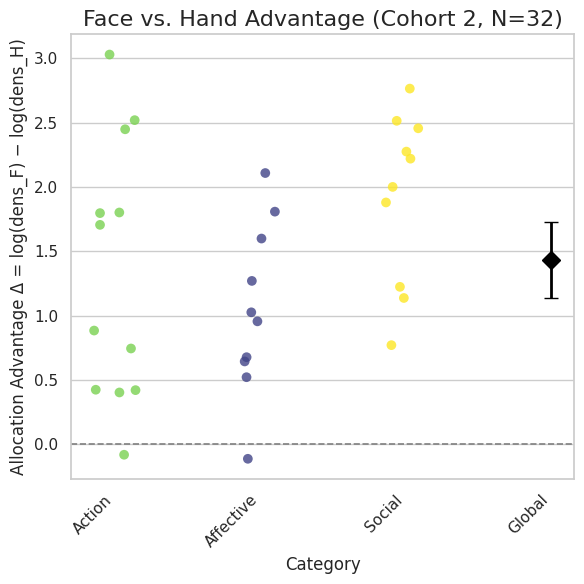

[saved] /home/nico/Projects/final_project/results/notebook05/section04/fig_face_hand_logodds.png
[saved] /home/nico/Projects/final_project/results/notebook05/section04/fig_face_hand_logodds.svg
[info] Wilcoxon zero differences dropped (C2) -> main=0, overlap-excluded=0  [saved] /home/nico/Projects/final_project/results/notebook05/section04/tbl_wilcoxon_zero_counts_c2.csv
[saved] /home/nico/Projects/final_project/results/notebook05/section04/per_image_log_ratios_c2.csv
[info] C2 Main: mean_log=1.432, CI_log=[1.133, 1.731], geo×=4.187, CI×=[3.10×, 5.64×]; Overlap-Excluded: mean_log=1.432, CI_log=[1.136, 1.723], geo×=4.187, CI×=[3.11×, 5.60×]


In [20]:
# --- Section 4: Primary Endpoint 2: Face vs. Hand (Cohort 2) ---

def per_image_face_hand_log_ratio(df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes per-image log-ratio (Delta) for Face vs. Hand.

    Returns
    -------
    DataFrame
        Copy with:
        - dens_F, dens_H: fixation densities
        - log_ratio: log(dens_F) - log(dens_H)
    """
    d = df.copy()
    d["dens_F"] = (d["n_F"] + ALPHA) / (d["A_F"] + BETA)
    d["dens_H"] = (d["n_H"] + ALPHA) / (d["A_H"] + BETA)
    d["log_ratio"] = np.log(d["dens_F"]) - np.log(d["dens_H"])
    return d

def _fmt_p_full(p: float, sigfigs: int = 6) -> str:
    """Format p-values with full precision using general format."""
    return "" if np.isnan(p) else f"{p:.{sigfigs}g}"

def _wilcoxon_auto(diffs: np.ndarray):
    """
    Wilcoxon signed-rank with automatic method selection.
    Uses 'exact' only when valid (n <= 25 and no ties after removing zeros),
    else 'approx'; falls back to 'auto' as a safety net.
    """
    d = np.asarray(diffs, float)
    d = d[~np.isnan(d)]
    d = d[d != 0]
    n = d.size
    if n == 0:
        return np.nan, np.nan
    has_ties = (np.unique(rankdata(np.abs(d), method="average")).size < n)
    method = "exact" if (n <= 25 and not has_ties) else "approx"
    try:
        stat, p = wilcoxon(d, alternative="two-sided", zero_method="wilcox", method=method)
    except Exception:
        stat, p = wilcoxon(d, alternative="two-sided", zero_method="wilcox", method="auto")
    return stat, p

# --- 0. N bookkeeping (avoid hardcoding) ---
N_c2 = len(df_c2_analysis)
print(f"[info] Cohort 2 N = {N_c2} images")

# --- 1. Main Analysis (Precedence-based) ---
df_c2_lr = per_image_face_hand_log_ratio(df_c2_analysis)

# Bootstrap mean and CI (log scale), then exponentiate
mean_log_delta, (lo_delta, hi_delta) = bootstrap_mean_ci(df_c2_lr["log_ratio"].to_numpy(), seed=SEED)
exp_mean_delta = float(np.exp(mean_log_delta))
exp_ci_delta = (float(np.exp(lo_delta)), float(np.exp(hi_delta)))

# Wilcoxon (auto exact/approx) and rank-biserial r
diffs_c2 = df_c2_lr["log_ratio"].to_numpy()
wilcox_stat_c2, p_value_c2 = _wilcoxon_auto(diffs_c2)
r_biserial_c2 = rank_biserial_from_wilcoxon(diffs_c2)

# --- 2. Sensitivity Analysis (Overlap Exclusion) ---
H, W = int(config.IMG_HEIGHT), int(config.IMG_WIDTH)
rows_overlap_excluded = []
unions_root = config.RESULTS_DIR / "notebook04" / "section05" / "class_unions" / "cohort2"
if not unions_root.exists():
    raise FileNotFoundError(f"Expected unions at {unions_root}. Run Notebook 04 union export.")

n_with_overlap = 0
for _, row in df_c2_analysis.iterrows():
    stem = Path(row["filename"]).stem
    cat = row["category"]

    # Load RAW unions (may overlap)
    mask_f_raw = _load_bool_mask(unions_root / cat / f"{stem}_face.json", (H, W))
    mask_h_raw = _load_bool_mask(unions_root / cat / f"{stem}_hand.json", (H, W))
    if mask_f_raw is None or mask_h_raw is None:
        continue

    intersection = mask_f_raw & mask_h_raw
    if intersection.any():
        n_with_overlap += 1

    mask_f_disjoint = mask_f_raw & ~intersection
    mask_h_disjoint = mask_h_raw & ~intersection

    A_F_disjoint = int(mask_f_disjoint.sum())
    A_H_disjoint = int(mask_h_disjoint.sum())

    mat_path = config.FIXATIONLOCS_DIR / cat / f"{stem}.mat"
    fix_map, _, _ = _load_fixation_mat_robust(mat_path)
    n_F_disjoint = int(fix_map[mask_f_disjoint].sum())
    n_H_disjoint = int(fix_map[mask_h_disjoint].sum())

    rows_overlap_excluded.append({
        "image_id": row["image_id"], "category": cat,
        "n_F": n_F_disjoint, "n_H": n_H_disjoint,
        "A_F": A_F_disjoint, "A_H": A_H_disjoint
    })

if n_with_overlap == 0:
    print("[warn] Overlap-exclusion: no face∩hand intersections were found. "
          "This usually means precedence-disjoint masks (expected if built in Notebook 04).")

df_c2_oe = pd.DataFrame(rows_overlap_excluded)
if not df_c2_oe.empty:
    df_c2_oe_lr = per_image_face_hand_log_ratio(df_c2_oe)
    mean_log_oe, (lo_oe, hi_oe) = bootstrap_mean_ci(df_c2_oe_lr["log_ratio"].to_numpy(), seed=SEED + 1)
    exp_mean_oe = float(np.exp(mean_log_oe))
    exp_ci_oe = (float(np.exp(lo_oe)), float(np.exp(hi_oe)))

    # Wilcoxon and r for the overlap-excluded estimate
    diffs_oe = df_c2_oe_lr["log_ratio"].to_numpy()
    wilcox_stat_oe, p_value_oe = _wilcoxon_auto(diffs_oe)
    r_biserial_oe = rank_biserial_from_wilcoxon(diffs_oe)
else:
    # Fall back to main stats if nothing to recompute
    mean_log_oe, lo_oe, hi_oe = mean_log_delta, lo_delta, hi_delta
    exp_mean_oe, exp_ci_oe = exp_mean_delta, exp_ci_delta
    p_value_oe, r_biserial_oe = np.nan, np.nan

print(f"[info] Images with face∩hand overlap found: {n_with_overlap} / {N_c2}")

# --- 3. Store Results for Final Summary Table ---
c2_sensitivity_results = {
    "Main (Precedence)": {"mean_log": float(mean_log_delta), "ci": (float(lo_delta), float(hi_delta))},
    "Overlap-Exclusion": {"mean_log": float(mean_log_oe), "ci": (float(lo_oe), float(hi_oe))}
}
sens_path_c2 = get_output_path(4, "c2_sensitivity_results.json")
sens_path_c2.write_text(json.dumps(c2_sensitivity_results, indent=2), encoding="utf-8")
print(f"[saved] {sens_path_c2}")

# --- 4. Reporting and Visualization ---

summary_data_c2 = {
    "Estimate": ["Main (Precedence)", "Overlap-Exclusion"],
    "Mean Log Ratio": [mean_log_delta, mean_log_oe],
    "95% CI (Log)": [f"[{lo_delta:.3f}, {hi_delta:.3f}]", f"[{lo_oe:.3f}, {hi_oe:.3f}]"],
    "Geometric Mean Density Ratio (×)": [exp_mean_delta, exp_mean_oe],
    "95% CI (×)": [f"[{exp_ci_delta[0]:.2f}×, {exp_ci_delta[1]:.2f}×]",
                   f"[{exp_ci_oe[0]:.2f}×, {exp_ci_oe[1]:.2f}×]"],
    "Wilcoxon p-value": [_fmt_p_full(p_value_c2), _fmt_p_full(p_value_oe)],
    "Rank-biserial r": [r_biserial_c2, r_biserial_oe],
}
summary_table_c2 = pd.DataFrame(summary_data_c2)

summary_csv_path_c2 = get_output_path(4, "tbl_c2_primary_endpoint.csv")
summary_md_path_c2 = get_output_path(4, "tbl_c2_primary_endpoint.md")
summary_table_c2.to_csv(summary_csv_path_c2, index=False)
save_dataframe_as_markdown(summary_table_c2, summary_md_path_c2, title=f"Face vs. Hand Advantage (Cohort 2, N={N_c2})")

print("\n[table] Face vs. Hand Advantage")
display(summary_table_c2.style.format(precision=3))

# ---- Plot: categories present only, using config colors ----
present_cats = [c for c in getattr(config, "ANTHROPOMORPHIC_CATEGORIES", ["Action", "Affective", "Social"])
                if c in df_c2_lr["category"].unique()]
anthro_order = present_cats
anthro_palette = {c: config.CATEGORY_COLORS[c] for c in anthro_order}

df_plot = df_c2_lr[df_c2_lr["category"].isin(anthro_order)].copy()

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
sns.stripplot(
    data=df_plot,
    x="category",
    y="log_ratio",
    hue="category",
    order=anthro_order,
    hue_order=anthro_order,
    palette=anthro_palette,
    jitter=0.15,
    size=7,
    alpha=0.8,
    ax=ax,
)
if ax.legend_ is not None:
    ax.legend_.remove()

ax.axhline(0.0, color="gray", linestyle="--", linewidth=1.2)

# Global mean and CI at the rightmost position
x_global = len(anthro_order)
ax.plot([x_global], [mean_log_delta], "kD", markersize=9, label="Global Mean")
ax.errorbar([x_global], [mean_log_delta],
            yerr=[[mean_log_delta - lo_delta], [hi_delta - mean_log_delta]],
            fmt="none", color="k", capsize=5, lw=2)

ax.set_xticks(list(range(len(anthro_order))) + [x_global])
ax.set_xticklabels(anthro_order + ["Global"], rotation=45, ha="right")

ax.set_title(f"Face vs. Hand Advantage (Cohort 2, N={N_c2})", fontsize=16)
ax.set_xlabel("Category", fontsize=12)
ax.set_ylabel("Allocation Advantage Δ = log(dens_F) − log(dens_H)", fontsize=12)
plt.tight_layout()

# Save figure
fig_png_path_c2 = get_output_path(4, "fig_face_hand_logodds.png")
fig_svg_path_c2 = get_output_path(4, "fig_face_hand_logodds.svg")
plt.savefig(fig_png_path_c2, dpi=300)
plt.savefig(fig_svg_path_c2)
plt.show()

print(f"[saved] {fig_png_path_c2}")
print(f"[saved] {fig_svg_path_c2}")

# --- 5. QC and per-image exports (fast, high-value) ---

# Wilcoxon zero-differences audit for transparency
zeros_main = int(np.sum(np.isclose(diffs_c2, 0.0)))
if 'df_c2_oe_lr' in locals():
    zeros_oe = int(np.sum(np.isclose(df_c2_oe_lr["log_ratio"].to_numpy(), 0.0)))
else:
    zeros_oe = 0
zero_csv_c2 = get_output_path(4, "tbl_wilcoxon_zero_counts_c2.csv")
pd.DataFrame({"estimate": ["Main", "Overlap-Excluded"], "zero_diffs": [zeros_main, zeros_oe]}).to_csv(
    zero_csv_c2, index=False
)
print(f"[info] Wilcoxon zero differences dropped (C2) -> main={zeros_main}, overlap-excluded={zeros_oe}  [saved] {zero_csv_c2}")

# Persist per-image stats for auditability
per_image_path_c2 = get_output_path(4, "per_image_log_ratios_c2.csv")
df_c2_lr[["image_id", "category", "dens_F", "dens_H", "log_ratio"]].to_csv(per_image_path_c2, index=False)
print(f"[saved] {per_image_path_c2}")

# One-line console summary for manuscript
print(
    "[info] C2 Main: mean_log={:.3f}, CI_log=[{:.3f}, {:.3f}], geo×={:.3f}, CI×=[{:.2f}×, {:.2f}×]; "
    "Overlap-Excluded: mean_log={:.3f}, CI_log=[{:.3f}, {:.3f}], geo×={:.3f}, CI×=[{:.2f}×, {:.2f}×]".format(
        mean_log_delta, lo_delta, hi_delta, exp_mean_delta, exp_ci_delta[0], exp_ci_delta[1],
        mean_log_oe, lo_oe, hi_oe, exp_mean_oe, exp_ci_oe[0], exp_ci_oe[1]
    )
)

**Results**

For Cohort 2, the mean log density ratio Δ = log(dens\_F) - log(dens\_H) was 1.432 with a 95% CI \[1.133, 1.731]. This corresponds to a geometric mean density ratio of 4.187× with CI \[3.10×, 5.64×]. The Wilcoxon signed-rank test against a median of zero yielded p = 1.05858e-06, and the rank-biserial effect size was r = 0.989.
The overlap-exclusion sensitivity produced the same point estimate, mean log Δ = 1.432 with 95% CI \[1.136, 1.723], corresponding to 4.187× with CI \[3.11×, 5.60×]. No face∩hand intersections were present in the masks used here, so the overlap-exclusion test is expected to match the main estimate, consistent with the precedence-disjoint masks constructed in Notebook 04.

**Interpretation**

Faces drew substantially higher fixation density than hands. On average, a pixel in a face region received about 4.2 times the fixation density of a pixel in a hand region. The effect is large and precisely estimated; the signed-rank p-value is very small and the rank-biserial coefficient near 1 indicates that Δ is positive for nearly all images rather than being driven by a few outliers. The per-category scatter plot shows the advantage across Action, Affective, and Social images with modest variation in magnitude. 

**Conclusion**

Cohort 2 supports the second primary hypothesis: within person regions, faces dominate hands in attracting fixations. The effect is statistically strong, reinforcing a clear attentional hierarchy within social targets.

---

### **Section 5: Synthesis and Final Reporting**

**Objective**

To consolidate all primary and sensitivity results from the preceding sections into compact, summary tables and to provide a clear, auditable summary of the data funnel from initial image triage to the final analysis cohorts.

**Rationale**

A series of analyses were conducted to test the project’s hypotheses and their robustness. This final section synthesizes these results into a coherent narrative. The stress-test tables summarize how the primary findings hold up against potential confounders. The CONSORT-style flow table documents the selection pipeline to ensure methodological transparency.

**Methodology**

We load the artifacts produced earlier and build:

1. **Stress-test tables:** for Cohort 1 and Cohort 2, reporting the mean log ratio, its 95 percent CI, and the geometric mean density ratio with CI on the × scale.
2. **CONSORT-style flow:** summarizing image counts at each curation stage, globally and per category.

In [28]:
# --- Section 5: Synthesis and Final Reporting ---

def _col_first(df: pd.DataFrame, names: list[str]) -> str:
    """Return the first existing column name from 'names'; raise if none found."""
    for n in names:
        if n in df.columns:
            return n
    raise KeyError(f"None of the expected columns found: {names}")

def _get_json_key(d: dict, candidates: list[str]) -> str | None:
    """Case-insensitive key resolver for small naming drift across sections."""
    keys_lc = {k.lower(): k for k in d.keys()}
    for c in candidates:
        k = keys_lc.get(c.lower())
        if k is not None:
            return k
    return None

def _find_triage_candidate_col(df: pd.DataFrame) -> str:
    """Safely locate the triage candidate flag column."""
    candidates = ["any_anthropomorphic", "any_social", "is_person_candidate", "person_prompt", "run_person"]
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"No triage candidate flag found among: {candidates}")

def _enforce_category_order_local(df: pd.DataFrame, col: str = "category") -> pd.DataFrame:
    """Local category-order enforcement with non-standard rows kept at end."""
    if col not in df.columns:
        return df.copy()
    d = df.copy()
    d[col] = d[col].astype(str)
    co = list(getattr(config, "CAT_ORDER", []))
    mask = d[col].isin(co)
    ordered = d.loc[mask].copy()
    rest = d.loc[~mask].copy()
    if not ordered.empty:
        present = [c for c in co if c in ordered[col].unique()]
        dtype = pd.CategoricalDtype(present, ordered=True)
        ordered[col] = ordered[col].astype(dtype)
        ordered = ordered.sort_values(col)
    return pd.concat([ordered, rest]).reset_index(drop=True)

def _attach_category(list_df: pd.DataFrame, qc_df: pd.DataFrame) -> pd.DataFrame:
    """
    Ensure the list dataframe has a single 'category' column after merge.
    Prefer an existing non-null 'category' in list_df; otherwise fill from qc_df.
    """
    out = list_df.copy()
    base = out if ("category" in out.columns and out["category"].notna().any()) \
           else out.drop(columns=[c for c in out.columns if c in {"category"}], errors="ignore")

    merged = base.merge(
        qc_df[["image_id", "category"]].drop_duplicates(),
        on="image_id",
        how="left",
        suffixes=("", "_qc"),
    )
    if "category" in merged.columns and "category_qc" in merged.columns:
        merged["category"] = merged["category"].fillna(merged["category_qc"])
        merged = merged.drop(columns=["category_qc"])
    elif "category_qc" in merged.columns and "category" not in merged.columns:
        merged = merged.rename(columns={"category_qc": "category"})
    return merged

def _exp_ci_from_log_ci(log_lo: float, log_hi: float) -> tuple[float, float]:
    """Exponentiate log-scale CI to × scale."""
    return float(np.exp(log_lo)), float(np.exp(log_hi))

def _fmt_ci_pair(a: float, b: float, decimals: int) -> str:
    """Format [a, b] with fixed decimals."""
    return f"[{a:.{decimals}f}, {b:.{decimals}f}]"

def _fmt_ci_times(a: float, b: float, decimals: int) -> str:
    """Format [a×, b×] with fixed decimals."""
    return f"[{a:.{decimals}f}×, {b:.{decimals}f}×]"

# ---------- 1) Load artifacts ----------

print("[step] Loading all summary and sensitivity data...")

# Cohort 1 primary
c1_primary_path = get_output_path(2, "tbl_c1_primary_endpoint.csv")
df_c1_primary = pd.read_csv(c1_primary_path)

# Cohort 1 sensitivity
c1_sens_path = get_output_path(3, "c1_sensitivity_results.json")
with open(c1_sens_path, "r") as f:
    c1_sens_results = json.load(f)

# Cohort 2 sensitivity
c2_sens_path = get_output_path(4, "c2_sensitivity_results.json")
with open(c2_sens_path, "r") as f:
    c2_sens_results = json.load(f)

# Flow inputs
triage_path  = config.RESULTS_DIR / "notebook03" / "section03" / "tbl_triage_sets.csv"
qc_path      = config.RESULTS_DIR / "notebook04" / "section04" / "tbl_qc_image_cohorts.csv"
c1_list_path = config.RESULTS_DIR / "notebook04" / "section04" / "tbl_cohort1_image_list.csv"
c2_list_path = config.RESULTS_DIR / "notebook04" / "section04" / "tbl_cohort2_image_list.csv"

df_triage = pd.read_csv(triage_path)
df_qc = pd.read_csv(qc_path)
df_c1_final_list = pd.read_csv(c1_list_path)
df_c2_final_list = pd.read_csv(c2_list_path)

DEC = int(getattr(config, "DEFAULT_DECIMALS", 3))

# ---------- 2) Build stress-test tables ----------

# Resolve column names from C1 primary robustly
col_estimate = _col_first(df_c1_primary, ["Estimate"])
col_meanlog  = _col_first(df_c1_primary, ["Mean Log Ratio"])
col_cilog    = _col_first(df_c1_primary, ["95% CI (Log)"])
col_geox     = _col_first(df_c1_primary, ["Geometric Mean Density Ratio (×)", "Mean Density Ratio (×)"])
col_cix      = _col_first(df_c1_primary, ["95% CI (×)"]) if "95% CI (×)" in df_c1_primary.columns else None

# Build C1 stress rows from primary table
c1_stress_rows = []
for _, r in df_c1_primary.iterrows():
    c1_stress_rows.append({
        "Metric": r[col_estimate],
        "Mean Log Ratio": float(r[col_meanlog]),
        "95% CI (Log)": r[col_cilog], 
        "Geometric Mean Density Ratio (×)": float(r[col_geox]),
        "95% CI (×)": r[col_cix] if col_cix else ""
    })

# Add sensitivity entries
for name, res in c1_sens_results.items():
    mean_log = float(res["mean_log"])
    ci_lo, ci_hi = res.get("ci", (np.nan, np.nan))
    x_lo, x_hi = _exp_ci_from_log_ci(ci_lo, ci_hi) if np.isfinite(ci_lo) and np.isfinite(ci_hi) else (np.nan, np.nan)
    c1_stress_rows.append({
        "Metric": name,
        "Mean Log Ratio": mean_log,
        "95% CI (Log)": _fmt_ci_pair(ci_lo, ci_hi, DEC) if np.isfinite(ci_lo) else "N/A",
        "Geometric Mean Density Ratio (×)": float(np.exp(mean_log)),
        "95% CI (×)": _fmt_ci_times(x_lo, x_hi, DEC) if np.isfinite(x_lo) else "N/A"
    })

# Desired order with tolerant lookup for the eccentricity row
desired_order = [
    "Naive", "Center-Corrected",
    "Boundary-Exclusion", "Category-Balanced",
    "LOCO (min)", "LOCO (max)",
    "Eccentricity Q4 (Periphery)", "Eccentricity Q4 (periphery)",
    "LOO (min)", "LOO (max)",
]
# Deduplicate while preserving actual presence order
order_seen = []
for key in desired_order:
    idx = next((i for i, row in enumerate(c1_stress_rows) if row["Metric"] == key), None)
    if idx is None:
        idx = next((i for i, row in enumerate(c1_stress_rows) if row["Metric"].lower() == key.lower()), None)
    if idx is not None and idx not in order_seen:
        order_seen.append(idx)
order_seen += [i for i in range(len(c1_stress_rows)) if i not in order_seen]

df_c1_stress = pd.DataFrame([c1_stress_rows[i] for i in order_seen]).round(DEC)

# Cohort 2 stress table (JSON only)
c2_stress_rows = []
for label in ["Main (Precedence)", "Overlap-Exclusion"]:
    key = _get_json_key(c2_sens_results, [label])
    if key is None:
        continue
    res = c2_sens_results[key]
    mean_log = float(res["mean_log"])
    lo, hi = map(float, res["ci"])
    x_lo, x_hi = _exp_ci_from_log_ci(lo, hi)
    c2_stress_rows.append({
        "Metric": label,
        "Mean Log Ratio": mean_log,
        "95% CI (Log)": _fmt_ci_pair(lo, hi, DEC),
        "Geometric Mean Density Ratio (×)": float(np.exp(mean_log)),
        "95% CI (×)": _fmt_ci_times(x_lo, x_hi, DEC),
    })
df_c2_stress = pd.DataFrame(c2_stress_rows).round(DEC)

# Save and display stress-test tables 
c1_stress_csv = get_output_path(5, "tbl_c1_stress_test_summary.csv")
c1_stress_md  = get_output_path(5, "tbl_c1_stress_test_summary.md")
df_c1_stress.to_csv(c1_stress_csv, index=False)
save_dataframe_as_markdown(df_c1_stress, c1_stress_md, title="Cohort 1 Stress Test Summary")
print("\n[table] Cohort 1 Stress Test Summary")
display(df_c1_stress)

c2_stress_csv = get_output_path(5, "tbl_c2_stress_test_summary.csv")
c2_stress_md  = get_output_path(5, "tbl_c2_stress_test_summary.md")
df_c2_stress.to_csv(c2_stress_csv, index=False)
save_dataframe_as_markdown(df_c2_stress, c2_stress_md, title="Cohort 2 Stress Test Summary")
print("\n[table] Cohort 2 Stress Test Summary")
display(df_c2_stress)

# ---------- 3) CONSORT-style flow ----------

# Attach categories to final image lists if needed
df_c1_final_list = _attach_category(df_c1_final_list, df_qc)
df_c2_final_list = _attach_category(df_c2_final_list, df_qc)

# Stage 1: Initial candidates (person prompt flag)
candidate_col = _find_triage_candidate_col(df_triage)
s1 = (
    df_triage[df_triage[candidate_col] == 1]
    .groupby("category", observed=True)
    .size()
    .rename("Initial Candidates")
)

# Stage 2: Passed Manual QC flags for each cohort (Notebook 04)
if not {"cohort_1", "cohort_2"}.issubset(df_qc.columns):
    missing = {"cohort_1", "cohort_2"} - set(df_qc.columns)
    raise KeyError(f"QC table missing required cohort flags: {sorted(missing)}")

s2 = (
    df_qc[df_qc["cohort_1"] == 1]
    .groupby("category", observed=True)
    .size()
    .rename("Passed QC (Cohort 1)")
)
s3 = (
    df_qc[df_qc["cohort_2"] == 1]
    .groupby("category", observed=True)
    .size()
    .rename("Passed QC (Cohort 2)")
)

# Stage 3: Final cohorts after all automated checks
s4 = df_c1_final_list.groupby("category", observed=True).size().rename("Final Cohort 1")
s5 = df_c2_final_list.groupby("category", observed=True).size().rename("Final Cohort 2")

df_flow = pd.concat([s1, s2, s3, s4, s5], axis=1).fillna(0).astype(int)
df_flow.loc["Global"] = df_flow.sum(numeric_only=True)
df_flow = df_flow.reset_index().rename(columns={"index": "category"})
df_flow = _enforce_category_order_local(df_flow, col="category")

# Save and display flow table
flow_csv = get_output_path(5, "tbl_consort_flow_summary.csv")
flow_md  = get_output_path(5, "tbl_consort_flow_summary.md")
df_flow.to_csv(flow_csv, index=False)
save_dataframe_as_markdown(df_flow, flow_md, title="CONSORT-style Data Flow Summary")

print("\n[table] CONSORT-style Data Flow Summary")
display(df_flow)

[step] Loading all summary and sensitivity data...
[saved] /home/nico/Projects/final_project/results/notebook05/section05/tbl_c1_stress_test_summary.md

[table] Cohort 1 Stress Test Summary


,Metric,Mean Log Ratio,95% CI (Log),Geometric Mean Density Ratio (×),95% CI (×)
0,Naive,2.131,"[1.997, 2.266]",8.424,"[7.37×, 9.64×]"
1,Center-Corrected,0.994,"[0.898, 1.092]",2.702,"[2.46×, 2.98×]"
2,Boundary-Exclusion,1.006,"[0.806, 1.216]",2.735,"[2.240×, 3.375×]"
3,Category-Balanced,2.041,"[1.490, 2.436]",7.695,"[4.439×, 11.426×]"
4,LOCO (min),1.968,N/A,7.159,N/A
5,LOCO (max),2.301,N/A,9.987,N/A
6,Eccentricity Q4 (periphery),1.779,N/A,5.923,N/A
7,LOO (min),2.115,N/A,8.292,N/A
8,LOO (max),2.148,N/A,8.564,N/A


[saved] /home/nico/Projects/final_project/results/notebook05/section05/tbl_c2_stress_test_summary.md

[table] Cohort 2 Stress Test Summary


,Metric,Mean Log Ratio,95% CI (Log),Geometric Mean Density Ratio (×),95% CI (×)
0,Main (Precedence),1.432,"[1.133, 1.731]",4.187,"[3.105×, 5.644×]"
1,Overlap-Exclusion,1.432,"[1.136, 1.723]",4.187,"[3.114×, 5.599×]"


[saved] /home/nico/Projects/final_project/results/notebook05/section05/tbl_consort_flow_summary.md

[table] CONSORT-style Data Flow Summary


,category,Initial Candidates,Passed QC (Cohort 1),Passed QC (Cohort 2),Final Cohort 1,Final Cohort 2
0,Action,99,80,12,80,12
1,Affective,77,63,10,63,10
2,Social,100,38,10,38,10
3,Global,276,181,32,181,32
